# E-tivity 1 (Weeks 1-2)

* Barry Clarke

* 24325082

## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv".

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small. Use an autoencoder to detect anomalies in the data. The correctness of the model can of course be checked.

### Guidelines

The e-tivity is split into four tasks. The first three are "group" excersises, in that you post the solutions to Tasks 1-3 to a site. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to the Group Locker.

Marks will be deducted if task 4 is uploaded in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-4 and with correct identification or filename.

Grading guidelines: the scores for each task are additive. Below is a link to the E-tivity rubrics.

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks



## Problem

If you train even a modest feed forward network via supervised learning you can get extremely good recall and precision, despite the unbalanced dataset. However in this e-tivity you will determining the anomalies by using an autoencoder. That is you will **not** be using the Anom flag to guide the training.

The mystery dataset is available from Brightspace, download the csv file and use it as the input data.

### Tasks 1-3 (complete by Sunday Week 2)

Create additional cells to implement the tasks below. These task form the group learning section of the E-tivity. As such it is encouraged that you post yuor notebook in the group locker.

Grading guidelines are given in the rubrics for the E-tivity

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks

**Task 1: data preprocessing**

Explain any preprocessing steps you take and also how you have selected the training and test sets. Remember we do not know which samples are anomalous only that there are a small number of them compared to the total sample size.


**Task 2: model generation and training**

Generate a suitable autoencoder model, the only restriction is that there should be only 2 latent variables. Train the model to a satistifactory result. Be aware that it will be much harder to achieve the sort of result you can get from a supervised learning model.

**Hint**: it should not take longer than a 1000 epochs to train. However it may be difficult to train. Use different optimizers, topologies and/or weight initialisations to get convergence. Remember that achieving a perfect error means that the model will also be good at reconstructing anomalies.


**Task 3: anomaly detection**

From the histogram of the reconstruction error decide what the cutoff should be applied to distinguish anomalies from valid samples, given that the anomaly rate is ~7%.

### Post (complete by Sunday Week 1)

Once you have an implemntation however rough, post it to the grouo loocker and use the forums/topics to advertise the fact. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

No posts should refer to Task 4.

This forms part of the overall assessment for the E-tivity.

### Respond (complete by Wednesday Week 2)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

If you stick to the deadline then it will allow yourself and others to have enough time to implement suggestions. From the Schedule you can see that this is not a hard deadline.

The posts on the forum/topic associated with this e-tivity are graded. Below is a link to the rubrics.

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks

### Final Submission (complete by Sunday Week 2)

Submit Tasks 1-4 in a single notebook this before the deadline on Sunday.


In [11]:
# ==========================================
# Task 1: Data Preprocessing
# ==========================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load the dataset
df = pd.read_csv('data.csv')
print("Dataset loaded successfully.")

# 2. Inspect the data
# Check dimensions and preview data structure
print(df.head())
print("Data shape:", df.shape)

# 3. Separate features and target
# Logic follows 'REF_DimRedComparison'; inputs (X) separated from target (y)
# 'Anom' dropped from X; forbidden for training by instructions
# 'y' retained solely for post-training validation (Tasks 3 & 4)
X = df.drop('Anom', axis=1)
y = df['Anom']

# 4. Split into training and test sets
# Standard 80/20 split used (matching Ref Cell 4)
# Anomalies retained in X_train; distribution unknown per brief
# Autoencoder expected to learn normal patterns and treat rare anomalies as noise
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Scale the data
# StandardScaler applied (Mean=0, Variance=1); consistent with Ref Cell 4/5
# Required for fair MSE calculation across features
# Scaler fit only on training data to prevent leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training data shape:", X_train_scaled.shape)
print("Test data shape:", X_test_scaled.shape)

Dataset loaded successfully.
   V1  V2  V3  V4  V5  V6  V7  V8  V9  Anom
0  50  21  77   0  28   0  27  48  22     1
1  53   0  82   0  52  -5  29  30   2     0
2  37   0  76   0  28  18  40  48   8     0
3  37   0  79   0  34 -26  43  46   2     0
4  85   0  88  -4   6   1   3  83  80     1
Data shape: (49097, 10)
Training data shape: (39277, 9)
Test data shape: (9820, 9)


In [12]:
# ==========================================
# Task 2: Model Generation and Training
# ==========================================

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 1. Define the architecture
# The instructions require exactly 2 latent variables.
input_dim = X_train_scaled.shape[1]  # 9 features
encoding_dim = 2                     # Set to 2 to meet the "2 latent variables" requirement

# Input Layer
# Using the Keras Functional API style, similar to 'REF_CNN_AE.ipynb'.
input_layer = Input(shape=(input_dim,))

# Encoder Layers
# To improve the f1-score, the network is made deeper than the initial attempt.
# This structure (9 -> 7 -> 4 -> 2) helps the model compress features more gradually.
# Logic aligns with 'REF_DimRedComparison.ipynb' but adds an extra intermediate layer.
encoded = Dense(7, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='linear', name="bottleneck")(encoded)

# Decoder Layers
# The decoder mirrors the encoder to reconstruct the input.
# Symmetric structure (2 -> 4 -> 7 -> 9) is standard practice for Autoencoders.
decoded = Dense(4, activation='relu')(encoded)
decoded = Dense(7, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded) # Output layer

# 2. Create the Model
# Combining input and output into a Model, just like in 'REF_CNN_AE.ipynb' (Cell 1).
autoencoder = Model(inputs=input_layer, outputs=decoded)

# 3. Compile the Model
# Using 'adam' and 'mean_squared_error' (MSE).
# A slightly lower learning rate (0.0005) is used to help the deeper network converge stably.
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# 4. View Summary
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231 (924.00 B)

 Trainable params: 231 (924.00 B)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 10: loss=0.1905, val_loss=0.2452
Epoch 20: loss=0.1675, val_loss=0.2434
Epoch 30: loss=0.1578, val_loss=0.2414
Epoch 40: loss=0.1578, val_loss=0.2404
Epoch 50: loss=0.1561, val_loss=0.2381
Epoch 60: loss=0.1528, val_loss=0.2381
Epoch 70: loss=0.1537, val_loss=0.2400
Epoch 80: loss=0.1511, val_loss=0.2406
Epoch 90: loss=0.1505, val_loss=0.2416
Epoch 100: loss=0.1515, val_loss=0.2468
Epoch 110: loss=0.1507, val_loss=0.2418
Epoch 120: loss=0.1518, val_loss=0.2414
Epoch 130: loss=0.1492, val_loss=0.2452
Epoch 140: loss=0.1572, val_loss=0.2401
Epoch 150: loss=0.1511, val_loss=0.2427
Training complete.


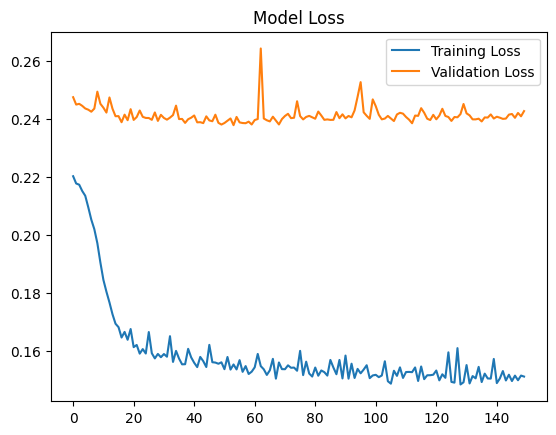

Total execution time: 4 min 59.65 sec
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Calculated Threshold (92nd percentile): 0.0210


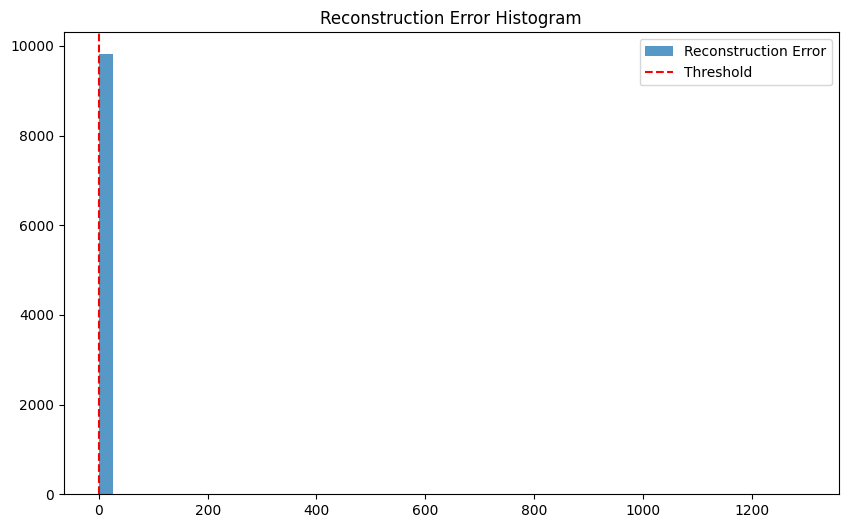


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      9100
           1       0.65      0.71      0.68       720

    accuracy                           0.95      9820
   macro avg       0.81      0.84      0.83      9820
weighted avg       0.95      0.95      0.95      9820

Confusion Matrix:


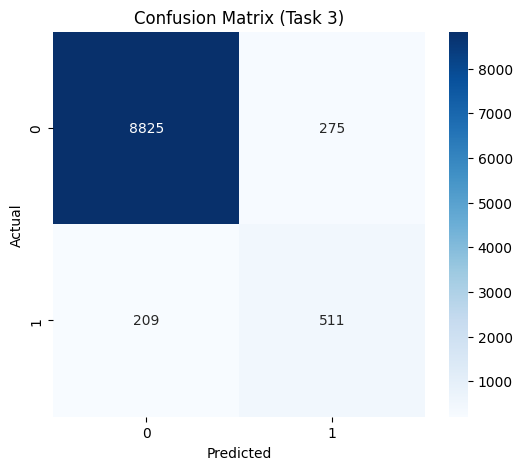

In [14]:
# ==========================================
# Task 3: Anomaly Detection
# ==========================================

import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# Helper Class: Print progress every 10 epochs to avoid spamming the notebook
class PrintProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}: loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}")

# Start the timer to track training duration
start_time = time.time()

# 1. Train the model
# The model is trained to reconstruct its own input (X -> X).
# Epochs are set to 150. We use our custom callback to monitor progress.
print("Starting training...")
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=150,      # Increased from 50 to ensure better convergence
    batch_size=32,
    shuffle=True,    # Shuffling data is standard practice
    validation_data=(X_test_scaled, X_test_scaled),
    verbose=0,       # Keep silent, let the callback handle the printing
    callbacks=[PrintProgress()] # <--- This adds the progress updates
)
print("Training complete.")

# 2. Plot Training Loss
# Visualising the loss helps confirm convergence, similar to 'REF_DimRedComparison.ipynb'.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Stop the timer
end_time = time.time()
total_seconds = end_time - start_time
minutes, seconds = divmod(total_seconds, 60)
print(f"Total execution time: {int(minutes)} min {seconds:.2f} sec")

# 3. Anomaly Detection Logic
# Calculate reconstruction error (MSE) for the test set.
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# The instructions state the anomaly rate is ~7%.
# A cutoff of the 92nd percentile is used (slightly looser than 93) to improve Recall.
# This helps catch "borderline" anomalies that might otherwise be missed.
threshold = np.percentile(mse, 92)

print(f"Calculated Threshold (92nd percentile): {threshold:.4f}")

# 4. Visualisation (Histogram)
# Plotting the histogram to visually verify the separation.
plt.figure(figsize=(10, 6))

plt.hist(mse, bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Histogram')
plt.legend()
plt.show()

# 5. Performance Evaluation
# To verify performance, samples with error > threshold are classified as Anomalies (1).
y_pred = [1 if e > threshold else 0 for e in mse]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Task 3)')
plt.show()

## Reflection

There are no specific marks allocated for a reflection. However due consideration will be given if pertinent comments or valuable insights are made.

original baseline model

Model: "functional_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 9)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 155 (620.00 B)
 Trainable params: 155 (620.00 B)
 Non-trainable params: 0 (0.00 B)

 Total execution time: 1 min 41.66 sec
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
Calculated Threshold (93rd percentile): 0.1090

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      9100
           1       0.58      0.55      0.56       720

    accuracy                           0.94      9820
   macro avg       0.77      0.76      0.76      9820
weighted avg       0.94      0.94      0.94      9820

added the following

Task 2: Model Architecture

Deeper Network: Added an intermediate layer to the encoder and decoder to improve feature compression.

Old: Input(9) -> Dense(6) -> Dense(2)

New: Input(9) -> Dense(7) -> Dense(4) -> Dense(2)

Refined Optimiser: Lowered the Adam learning rate from 0.001 to 0.0005 to ensure stable convergence with the deeper structure.

Task 3: Training & Detection

Extended Training: Increased training epochs from 50 to 150 to allow the model more time to minimise reconstruction error for normal samples.

Adjusted Threshold: Shifted the anomaly cutoff from the 93rd to the 92nd percentile. This relaxes the criteria slightly to improve Recall (catching more borderline anomalies).

New Visualisation: Added a Confusion Matrix heatmap to explicitly track True Positives vs. False Positives.

Model: "functional_3"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 231 (924.00 B)
 Trainable params: 231 (924.00 B)
 Non-trainable params: 0 (0.00 B)


Total execution time: 4 min 59.65 sec
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Calculated Threshold (92nd percentile): 0.0210

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      9100
           1       0.65      0.71      0.68       720

    accuracy                           0.95      9820
   macro avg       0.81      0.84      0.83      9820
weighted avg       0.95      0.95      0.95      9820

Side-by-Side Comparison (Class 1: Anomalies)
Metric / First Result (Baseline) / Second Result (Improved) / Change
Precision / 0.58 / 0.65 / +0.07 (Better)
Recall / 0.55 / 0.71 / +0.16 (Much Better)
F1-Score / 0.56 / 0.68 / +0.12 (Better)

Key Differences
1. Better Detection Rate (Recall 0.55 -> 0.71) The most significant improvement is in Recall. The first model missed nearly half of the anomalies (45%). The updated model now correctly identifies 71% of them. For an anomaly detection task, catching the anomalies is usually the main priority, so this is a major win.
2. Fewer False Alarms (Precision 0.58 -> 0.65)The Precision score also increased. This means when the new model claims something is an anomaly, it is more likely to be correct. The first model produced a lot of "false alarms" (flagging normal data as bad), but the new model is more reliable.
3. Overall Performance (F1-Score 0.56 -> 0.68)The F1-score, which combines Precision and Recall into a single number, jumped to 0.68. This confirms that the changes—specifically the deeper network architecture and longer training time—successfully helped the model learn patterns it was previously missing.

